In [46]:
import torch
from torch import nn
import pandas as pd
import json
import requests
from io import StringIO
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [ ]:
def save_sp500_data():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # 1. Define a "User-Agent" to look like a standard browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    try:
        # 2. Fetch the content using requests (with the headers)
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Check for other errors (like 404)

        # 3. Pass the HTML text to pandas using StringIO 
        # (Direct string passing is deprecated in some versions)
        tables = pd.read_html(StringIO(response.text))
        df = tables[0]
        
        # --- The rest of your processing logic stays the same ---
        
        # Select specific columns: Symbol, Security Name, and GICS Sector
        df = df[['Symbol', 'Security', 'GICS Sector']]
        df.columns = ['ticker', 'name', 'sector']
        
        # CLEANING: Replace '.' with '-'
        df['ticker'] = df['ticker'].str.replace('.', '-', regex=False)
        
        # Convert to dictionary
        companies = df.to_dict('records')
        
        # Create final structure
        data = {
            "count": len(companies),
            "source": "Wikipedia",
            "companies": companies
        }
        
        # Save to JSON
        with open('sp500_data.json', 'w') as f:
            json.dump(data, f, indent=4)
            
        print(f"Successfully saved {len(companies)} companies to sp500_data.json")
        print(f"Sample: {companies[0]}")
        
    except Exception as e:
        print(f"Error extracting data: {e}")

In [5]:
save_sp500_data()

Successfully saved 503 companies to sp500_data.json
Sample: {'ticker': 'MMM', 'name': '3M', 'sector': 'Industrials'}


C:\Users\mrsim\AppData\Local\Temp\ipykernel_31820\2155652791.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ticker'] = df['ticker'].str.replace('.', '-', regex=False)


In [ ]:
def get_mfv(ticker, period='1y'):
    comp = yf.Ticker(ticker)
    data = comp.history(period=period)
    high_low_range = data['High'] - data['Low']
    data['MFM'] = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / high_low_range
    data['MFV'] = round(data['MFM'] * data['Volume'], 1)
    return data['MFV']

In [ ]:
ticker='AAPL'
period='2y'
mfv_df = get_mfv(ticker, period=period)
price = yf.Ticker(ticker).history(period=period)

In [ ]:
avg_value = mfv_df.mean().round(1)
avg = pd.Series(avg_value, index=mfv_df.index)
ma10 = mfv_df.rolling(window=10).mean().round(1)
ma60 = mfv_df.rolling(window=60).mean().round(1)
ma120 = mfv_df.rolling(window=120).mean().round(1)
ma240 = mfv_df.rolling(window=240).mean().round(1)
ma_df = pd.concat([avg, ma10, ma60, ma120, ma240], axis=1)
ma_df.columns = ['avg', 'ma10', 'ma60', 'ma120', 'ma240']

In [83]:
ma_df

,avg,ma10,ma60,ma120,ma240
Date,,,,,
2024-01-08 00:00:00-05:00,2143762.5,NaN,NaN,NaN,NaN
2024-01-09 00:00:00-05:00,2143762.5,NaN,NaN,NaN,NaN
2024-01-10 00:00:00-05:00,2143762.5,NaN,NaN,NaN,NaN
2024-01-11 00:00:00-05:00,2143762.5,NaN,NaN,NaN,NaN
2024-01-12 00:00:00-05:00,2143762.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-12-29 00:00:00-05:00,2143762.5,5522648.8,1596336.5,2043810.6,2512430.7
2025-12-30 00:00:00-05:00,2143762.5,8566000.1,1113957.1,1882677.4,2416083.3
2025-12-31 00:00:00-05:00,2143762.5,4189213.4,847940.2,1632979.3,2600536.7


In [90]:
prev = ma_df.shift(1)
cond_today = ma_df['ma10'] > ma_df['ma60']
cond_yesterday = prev['ma10'] <= prev['ma60']
golden_cross_df = ma_df[cond_today & cond_yesterday]

cond_today_inv = ma_df['ma10'] < ma_df['ma60']
cond_yesterday_inv = prev['ma10'] >= prev['ma60']
dead_cross_df = ma_df[cond_today_inv & cond_yesterday_inv]
print("골든크로스 발생 날짜 및 수치:")
print(golden_cross_df.index)
print("데드크로스 발생 날짜 및 수치:")
print(dead_cross_df.index)

골든크로스 발생 날짜 및 수치:
DatetimeIndex(['2024-04-12 00:00:00-04:00', '2024-05-02 00:00:00-04:00',
               '2024-05-14 00:00:00-04:00', '2024-05-17 00:00:00-04:00',
               '2024-05-31 00:00:00-04:00', '2024-07-08 00:00:00-04:00',
               '2024-08-06 00:00:00-04:00', '2024-09-09 00:00:00-04:00',
               '2024-10-04 00:00:00-04:00', '2024-10-21 00:00:00-04:00',
               '2024-10-29 00:00:00-04:00', '2024-11-14 00:00:00-05:00',
               '2024-12-20 00:00:00-05:00', '2025-01-29 00:00:00-05:00',
               '2025-02-14 00:00:00-05:00', '2025-02-24 00:00:00-05:00',
               '2025-03-24 00:00:00-04:00', '2025-04-11 00:00:00-04:00',
               '2025-04-21 00:00:00-04:00', '2025-06-26 00:00:00-04:00',
               '2025-06-30 00:00:00-04:00', '2025-07-02 00:00:00-04:00',
               '2025-07-09 00:00:00-04:00', '2025-08-12 00:00:00-04:00',
               '2025-08-26 00:00:00-04:00', '2025-09-19 00:00:00-04:00',
               '2025-10-07 00:00:

In [96]:
prev = ma_df.shift(1)
cond_gc = (ma_df['ma10'] > ma_df['ma60']) & (prev['ma10'] <= prev['ma60'])
cond_dc = (ma_df['ma10'] < ma_df['ma60']) & (prev['ma10'] >= prev['ma60'])
gc_points = ma_df[cond_gc]
dc_points = ma_df[cond_dc]

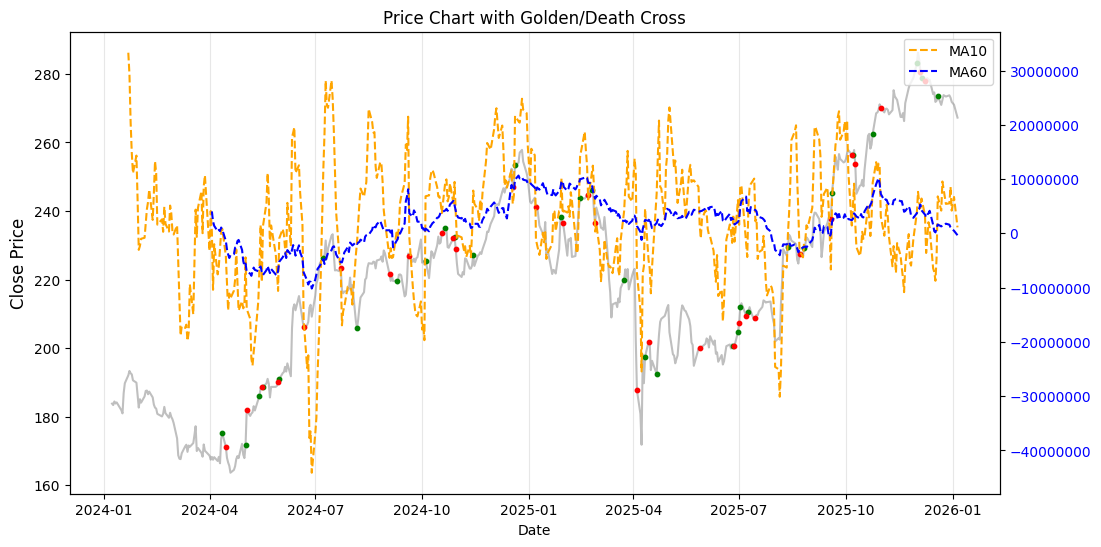

In [107]:
price_data = price

fig, ax1 = plt.subplots(figsize=(12, 6))

color_price = 'black'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color_price, fontsize=12)
ax1.plot(price_data.index, price_data['Close'], label='Close Price', color='gray', alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color_price)
ax1.grid(True, axis='x', alpha=0.3) # x축 기준 그리드만 표시

color_adl = 'blue'
ax2 = ax1.twinx()
ax2.plot(ma_df.index, ma_df['ma10'], label='MA10', color='orange', linestyle='--')
ax2.plot(ma_df.index, ma_df['ma60'], label='MA60', color='blue', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color_adl)
ax2.ticklabel_format(style='plain', axis='y')

# 2. 골든크로스 표시 (초록색 점)
# golden_cross_df의 인덱스(날짜)에 해당하는 'Close' 가격만 뽑아옵니다.
if not golden_cross_df.empty:
    ax1.scatter(golden_cross_df.index, 
                price_data.loc[golden_cross_df.index]['Close'], 
                color='green', s=10, zorder=5, label='Golden Cross')

# 3. 데드크로스 표시 (빨간색 점)
# dead_cross_df의 인덱스(날짜)에 해당하는 'Close' 가격만 뽑아옵니다.
if not dead_cross_df.empty:
    ax1.scatter(dead_cross_df.index, 
                price_data.loc[dead_cross_df.index]['Close'], 
                color='red', s=10, zorder=5, label='Death Cross')

plt.title("Price Chart with Golden/Death Cross")
plt.legend()
plt.show()

In [124]:
price_res = price.reset_index()
golden_cross_res = golden_cross_df.reset_index()
dead_cross_res = dead_cross_df.reset_index()

In [125]:
buy = price_res[price_res['Date'].isin(golden_cross_res['Date'])]
buy = buy[['Date', 'Close']]

In [ ]:
buy = price_res[price_res['Date'].isin(golden_cross_res['Date'])]
buy = buy[['Date', 'Close']]

sell = price_res[price_res['Date'].isin(dead_cross_res['Date'])]
sell = sell[['Date', 'Close']]